In [1]:
# # This is a Python block

!pip install ortools numpy pandas gurobipy matplotlib
!cp gurobi.lic ~/gurobi.lic



[notice] A new release of pip is available: 23.0.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:

def generate_all_data():
    # Generate data
    import random
    import matplotlib.pyplot as plt
    import csv


    data_dir = '/work/msci434-final-project/custom-data'


    # Set seed
    random.seed(8473625374845635637)

    # Each level of di

    def generate_data(num_stops = 5):
        tot_students = num_stops * 50
        err_margin_percentage = 0.05
        err_margin = round(tot_students * err_margin_percentage)
        tot_students += random.randint(-err_margin, err_margin)
        num_students = tot_students


        def generate_data_row():
            dimension_bounds = 50 + 3 * num_stops
            start_x = random.randint(-dimension_bounds, dimension_bounds)
            start_y = random.randint(-dimension_bounds, dimension_bounds)

            
            num_student_at_stop = min(random.randrange(70), num_students)
            # self.num_students -= num_student_at_stop

            return {
                'start_x': start_x,
                'start_y': start_y,
                'student_num': num_student_at_stop
            }

        

        stops = []

        while num_students > 0:
            row = generate_data_row()
            num_students_at_stop = row['student_num']
            if num_students_at_stop == 0:
                continue

            num_students -= num_students_at_stop
            stops.append(row)

        # Make sure there's enough vechicles
        vehicle_types = [250, 150, 100, 50]
        vehicles = []

        capacity_served = 0
        while capacity_served < 1.25 * tot_students:
            cap = random.choice(vehicle_types)
            capacity_served += cap
            vehicles.append(cap)
            
        vehicles.sort()

        
        return [stops, vehicles]

    problem_sizes = [1, 2, 3, 5, 10, 20, 30, 40, 50, 60, 80, 100, 200, 300]

    for size in problem_sizes:
        [stops, vehicles] = generate_data(num_stops=size)
        with open(f"{data_dir}/custom_test_file{str(size)}.csv", "wt") as f:
            writer = csv.DictWriter(f, fieldnames=['start_x', 'start_y', 'student_num'])

            writer.writeheader()
            writer.writerows(stops)
        
        with open(f"{data_dir}/custom_vehicle_file{str(size)}.csv", "wt") as f:
            # writer = csv.writer(f)
            # writer.writerow(["vehicle_capacity"])
            # writer.writerows(vehicles)
            f.writelines("vehicle_capacity\n")
            veh_str = list(map(lambda x: f"{str(x)}\n", vehicles))
            print(veh_str)
            f.writelines(veh_str)

# generate_all_data()




In [3]:
# List all data files

from glob import glob

# files = glob('/work/msci434-final-project/data/*.csv')
files = glob('/work/msci434-final-project/custom-data/*.csv')
files.sort()

In [31]:
csv_path = '/work/msci434-final-project/custom-data/custom_test_file300.csv'

In [32]:
import pandas as pd


# csv_path = "/work/msci434-final-project/data/hetero_test_file40.csv"
df = pd.read_csv(csv_path, sep=",", comment="#")


df


,start_x,start_y,student_num
0,783,-744,15
1,-459,524,20
2,427,289,46
3,95,-824,58
4,310,-45,69
...,...,...,...
440,11,95,42
441,-825,-155,43
442,-520,-374,39
443,833,-316,35


In [33]:
DeepnoteChart(df, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"circle","color":"#4c78a8","tooltip":true},"encoding":{"x":{"sort":null,"type":"quantitative","field":"start_x","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"y":{"sort":null,"type":"quantitative","field":"start_y","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"size":{"sort":null,"type":"quantitative","field":"student_num"}}}]},{"layer":[{"mark":{"clip":true,"type":"circle","color":"#f58518","tooltip":true},"encoding":{"x":{"sort":null,"type":"quantitative","field":"school_x","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"},"y":{"sort":null,"type":"quantitative","field":"school_y","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{}}""")

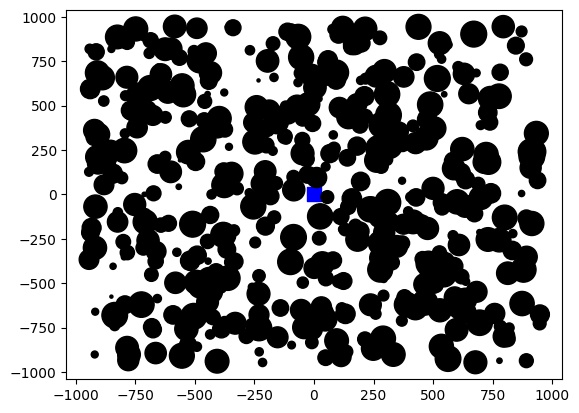

In [34]:
import matplotlib.pyplot as plt
def graph_stop_locations():
    plt.scatter(0, 0, c='b', marker='s', s=100)
    # x_coords = list(map(lambda x:  x['start_x'], stops))
    # y_coords = list(map(lambda x:  x['start_y'], stops))
    # student_nums = list(map(lambda x:  x['student_num'], stops))
    plt.scatter(df['start_x'], df['start_y'], c='k',  s=[x*5 for x in df['student_num']])

graph_stop_locations()

In [35]:
# See vehicles

vehicles_df = pd.read_csv(csv_path.replace('test', 'vehicle'), sep=" ")

vehicles_df



,vehicle_capacity
0,50
1,50
2,50
3,50
4,50
...,...
132,250
133,250
134,250
135,250


In [36]:
# Assume 7 vehicles, with 70 capacity each



from gurobipy import tupledict, tuplelist
from scipy.spatial import distance_matrix

# List of schools
# school_coords = df[['school_x', 'school_y']].drop_duplicates().rename(columns={'school_x': 'x', 'school_y': 'y'})

stop_coords = df[['start_x', 'start_y']].rename(columns={'start_x': 'x', 'start_y': 'y'})

depot_coords = pd.DataFrame({'x': [0, 0], 'y': [0, 0]})

# Depot is the school
# Then all the bus stops
all_coords = pd.concat([ depot_coords, stop_coords])


# Distance matrix
distances = pd.DataFrame(distance_matrix(all_coords.values, all_coords.values))
distances


,0,1,2,3,4,5,6,7,8,9,...,437,438,439,440,441,442,443,444,445,446
0,0.000000,0.000000,1080.104162,696.603905,515.606439,829.458257,313.249102,530.315001,249.070271,936.090273,...,1009.435981,701.257442,257.437371,797.895357,478.059620,95.634722,839.434333,640.527907,890.923678,1248.905120
1,0.000000,0.000000,1080.104162,696.603905,515.606439,829.458257,313.249102,530.315001,249.070271,936.090273,...,1009.435981,701.257442,257.437371,797.895357,478.059620,95.634722,839.434333,640.527907,890.923678,1248.905120
2,1080.104162,1080.104162,0.000000,1774.933238,1092.622991,692.635546,843.996445,1581.594449,1147.148203,1945.520496,...,272.117622,729.622505,851.986502,1114.145412,1547.762902,1140.133764,1712.479197,1354.514304,430.910664,2328.458932
3,696.603905,696.603905,1774.933238,0.000000,916.635696,1457.401798,956.620092,341.123145,678.177705,550.616019,...,1700.716320,1280.800141,929.346545,1256.536510,237.035862,636.349747,771.360486,900.069442,1541.059376,566.484775
4,515.606439,515.606439,1092.622991,916.635696,0.000000,1161.461579,353.899703,929.834394,298.760774,1341.269921,...,1150.082171,412.237795,416.811708,1266.802668,690.808946,459.011982,1328.397531,1156.018166,728.602086,1468.373931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
442,95.634722,95.634722,1140.133764,636.349747,459.011982,922.830970,330.152995,515.910845,170.182255,930.260716,...,1085.807073,699.353988,293.639234,889.384619,407.829621,0.000000,872.580082,708.464537,919.023939,1197.428077
443,839.434333,839.434333,1712.479197,771.360486,1328.397531,1137.524066,1140.317938,472.423539,1030.313545,376.198086,...,1530.033006,1532.048302,1070.291549,755.034436,799.775594,872.580082,0.000000,375.481025,1665.798607,981.994908
444,640.527907,640.527907,1354.514304,900.069442,1156.018166,762.053148,892.827531,559.472966,878.635305,704.193865,...,1159.891805,1271.560459,815.898278,399.530975,823.162803,708.464537,375.481025,0.000000,1354.242593,1266.380669
445,890.923678,890.923678,430.910664,1541.059376,728.602086,895.939730,589.041594,1421.232212,867.601867,1822.842286,...,616.769001,325.012307,633.609501,1234.097241,1304.381079,919.023939,1665.798607,1354.242593,0.000000,2107.396735


## Model

In [37]:
fz = [2000, 1000, 800, 600]
Z = list(range(len(fz)))
print(Z)

[0, 1, 2, 3]


In [38]:
import gurobipy as gp
from gurobipy import GRB

try:
    if model:
        model.close()
except:
    pass

model = gp.Model(name="SBRP")
model.modelSense = GRB.MINIMIZE
model.update()


I = list(range(2, len(distances)))
J = list(range(2, len(distances)))
# k = len(vehicles_df) # Number of buses active, assume capacity of 70
k = 4
fixed_cost_per_bus = 2000




# Cost to travel 1 unit of distance
cost_per_unit = 5
cij = distances * cost_per_unit 
d = distances

BigQ = 250 #  vehicle capacity
Qij = []
q = [0,0, *df['student_num'].values] # demand at node i
# q += [0] * (len(all_coords) -  len(q))

BigT = 2000000000 # Max Time/Distance

##################################################
########## DECISION VARIABLES ###################
##################################################
x = model.addVars([0,1, *I], [0,1, *J], lb=0.0, vtype=GRB.BINARY, name="is_edge_active")
u = model.addVars(I, lb=0.0, vtype=GRB.INTEGER, name="u") # number of students leaving node I
v = model.addVars(I, lb=0.0, vtype=GRB.INTEGER, name="v") # total distance traveled to reach node i

tslack = model.addVar(lb=0.0, vtype=GRB.INTEGER, name="BigTSlack")

##################################################
#################### GOALS #######################
##################################################
num_nodes = list(range(len(distances)))

model.setObjectiveN(gp.quicksum(cij[i][j] * x[(i, j)] for i in num_nodes for j in num_nodes), 1, name="Cost" )

model.setObjectiveN(tslack, 2, name="TSlack" )


##################################################
################# CONSTRAINTS ####################
##################################################
model.addConstr((x.sum(0, [*I]) <= k ) , name="(2) leaveDepotKTimes")
model.addConstr((x.sum([*I], 0) <= k ) , name="(3) enterDepotKTimes")
# list_I = list(range(1,15))
# Only leave each node once
model.addConstrs((gp.quicksum(x[(i,j)] for j in [1, *J]) == 1 for i in I), name="(4) leaveNodeOnce")
# Only enter each node once
model.addConstrs((gp.quicksum(x[(i,j)] for i in [0, *I]) == 1 for j in J), name="(5) enterNodeOnce")

model.addConstrs((x[(i, i)] == 0  for i in I), name="(lol) NoSelfConnect")

# contraints 6-8 are not used in the final model in the paper
model.addConstrs((BigQ * x[(i, j)] + (BigQ - q[i] - q[j]) * x[(j, i)] + u[i] - u[j] <= BigQ - q[j] for i in I for j in J if i != j), name='(9) subtourConstr1')
model.addConstrs(((u[i] >= q[i]) for i in I), name='(10) subtourConstr2')
model.addConstrs(((u[i] - q[i] * x[(0, i)] + BigQ * x[(0, i)] <= BigQ) for i in I), name='(11) subtourConstr3')

model.addConstrs(((BigT - d[i][1]  - d[0][j]  + d[i][j]) * x[(i,j)] + (BigT - d[i][1] - d[0][j] - d[j][i]) * x[(j,i)] + v[i] - v[j]  <= BigT - d[i][1] - d[0][j] for i in I for j in J if i != j ), name="(12)" )
model.addConstrs(((v[i] - d[0][i] * x[(0, i)] >= 0) for i in I), name="(13)" )
# model.addConstrs(((v[i] >= d[0][i] ) for i in I), name="(lmao)" )
model.addConstrs(((v[i] - d[0][i] * x[(0, i)] + BigT * x[(0, i)] <= BigT + tslack) for i in I), name="(14)")
# model.addConstrs(((v[i] - d[0][i] * x[(0, i)] + BigT * x[(0, i)] <= BigT) for i in I), name="(14)")

model.update()

In [12]:
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: AMD EPYC 7R13 Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Academic license - for non-commercial use only - registered to k44jiang@uwaterloo.ca
Optimize a model with 398277 rows, 200700 columns and 1982475 nonzeros
Model fingerprint: 0x77b4f315
Variable types: 0 continuous, 200700 integer (199809 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+09]
  Objective range  [1e+00, 1e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+09]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 3 objectives (1 combined) ...
---------------------------------------------------------------------------
----------------------------------------------------

In [28]:
# x

In [14]:
# Plot the solution
# From https://github.com/dholigum/cvrp-solver-gurobi/blob/master/CVRP-Gurobi.ipynb



arcs_dict = {}
for idx, arc in enumerate(x):
    is_arc_active = x[arc].getAttr(GRB.Attr.X) >= 0.999
    is_arc_start_at_zero = arc[0] == 0

    if is_arc_start_at_zero and is_arc_active:
        arcs_dict[idx] = [arc]

arcs_dict



{3: [(0, 3)], 5: [(0, 5)], 8: [(0, 8)], 10: [(0, 10)]}

In [15]:

for key in arcs_dict:
    first_point = arcs_dict[key][0][0]
    
    for step in range(len(x)):
        try:
            next_point = arcs_dict[key][step][1]
            for idx, arc in enumerate(x):
                is_arc_active = x[arc].getAttr(GRB.Attr.X) >= 0.999
                if (is_arc_active and next_point == arc[0] and next_point != first_point):
                    arcs_dict[key].append(arc)

        except IndexError:
            pass

arcs_dict


{3: [(0, 3), (3, 4), (4, 14), (14, 1)],
 5: [(0, 5), (5, 7), (7, 15), (15, 11), (11, 9), (9, 1)],
 8: [(0, 8), (8, 6), (6, 13), (13, 16), (16, 2), (2, 1)],
 10: [(0, 10), (10, 12), (12, 1)]}

In [16]:
# Add arrow to line
def add_arrow(line, position=None, direction='right', size=30, color=None):

    if color is None:
        color = line.get_color()

    xdata = line.get_xdata()
    ydata = line.get_ydata()

    if position is None:
        position = xdata.mean()
    # find closest index
    start_ind = np.argmin(np.absolute(xdata - position))
    if direction == 'right':
        end_ind = start_ind + 1
    else:
        end_ind = start_ind - 1

    line.axes.annotate('',
        xytext=(xdata[start_ind], ydata[start_ind]),
        xy=(xdata[end_ind], ydata[end_ind]),
        arrowprops=dict(arrowstyle="-|>", color=color),
        size=size
    )

In [17]:
def get_location_of_index(idx):
    if idx == 0 or idx == 1:
        return [0, 0]
    x_coord = df['start_x'][idx - 2]
    y_coord = df['start_y'][idx - 2]
    return [x_coord, y_coord]



Text(0.5, 1.0, 'SBRP Solution Map')

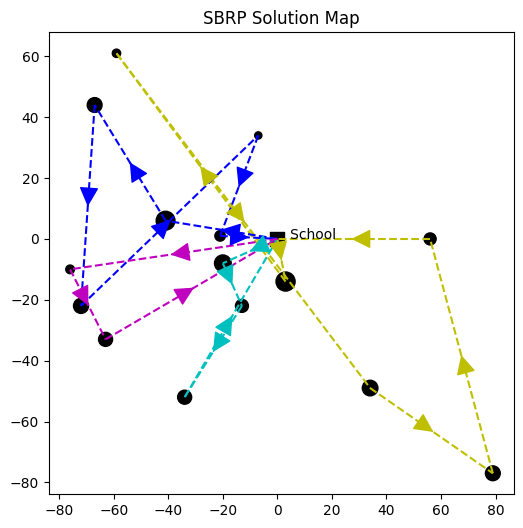

In [18]:
import numpy as np
import matplotlib.pyplot as plt

line_colors = ['r--', 'g--', 'b--', 'c--', 'm--', 'y--'] * 5

plt.figure(figsize=(6, 6))
for key, value in arcs_dict.items():
    for i, j in value:
        [x1, y1] = get_location_of_index(i)
        [x2, y2] = get_location_of_index(j)
        
        x = np.linspace(x1, x2, 100)
        y = np.linspace(y1, y2, 100)
        line = plt.plot(x, y, line_colors[key])[0]
        add_arrow(line)

plt.scatter(0, 0, c='k', marker='s', s=100)
plt.text(0, 0, s="   School")
plt.scatter(df['start_x'], df['start_y'], c='k', s=[x*3 for x in list(df['student_num'])])
plt.title("SBRP Solution Map")

In [19]:
tslack

<gurobi.Var BigTSlack (value 2.0)>

In [20]:
model.write('model.mps')
model.write('sol.mst')

In [21]:
for lmao in u:
    print(u[lmao].getAttr("x"))

166.0
48.0
77.0
63.0
99.0
75.0
61.0
180.0
13.0
155.0
47.0
138.0
111.0
117.0
147.0


In [22]:

model.close()

## Extension

In [29]:
import gurobipy as gp
from gurobipy import GRB



try:
    if model:
        model.close()
except:
    pass

model = gp.Model(name="SBRP")
model.modelSense = GRB.MINIMIZE
model.update()


I = list(range(2, len(distances)))
J = list(range(2, len(distances)))
# k = len(vehicles_df) # Number of buses active, assume capacity of 70
k = 4
fz = [2000, 1000, 800, 600]
Qz = [250, 150, 100, 50]
Z = list(range(len(Qz)))




# Cost to travel 1 unit of distance
cost_per_unit = 5
cij = distances * cost_per_unit 
d = distances

BigQ = 250 #  vehicle capacity

q = [0,0, *df['student_num'].values] # demand at node i
# q += [0] * (len(all_coords) -  len(q))

BigT = 200000 # Max Time/Distance

##################################################
########## DECISION VARIABLES ###################
##################################################
x = model.addVars([0,1, *I], [0,1, *J], Z, lb=0.0, vtype=GRB.BINARY, name="is_edge_active")
u = model.addVars(I, lb=0.0, vtype=GRB.INTEGER, name="u") # number of students leaving node I
v = model.addVars(I, lb=0.0, vtype=GRB.INTEGER, name="v") # total distance traveled to reach node i
# y = model.addVars(Z, lb=0, vtype=GRB.BINARY, name="is_bus_active")  

tslack = model.addVar(lb=0.0, vtype=GRB.INTEGER, name="BigTSlack")

##################################################
#################### GOALS #######################
##################################################
num_nodes = list(range(len(distances)))

model.setObjectiveN(gp.quicksum(cij[i][j] * x[(i, j, z)] for i in num_nodes for j in num_nodes for z in Z), 1, name="Cost" )

model.setObjectiveN(tslack, 2, name="TSlack" )


##################################################
################# CONSTRAINTS ####################
##################################################
model.addConstr((x.sum(0, [*I], [*Z]) <= k ) , name="(2) leaveDepotKTimes")
model.addConstr((x.sum([*I], 0, [*Z]) <= k ) , name="(3) enterDepotKTimes")
# list_I = list(range(1,15))
# Only leave each node once
model.addConstrs((gp.quicksum(x[(i,j,z)] for j in [1, *J]) == 1 for i in I for z in Z), name="(4) leaveNodeOnce")
# Only enter each node once
model.addConstrs((gp.quicksum(x[(i,j, z)] for i in [0, *I]) == 1 for j in J for z in Z), name="(5) enterNodeOnce")

model.addConstrs((x[(i, i, z)] == 0  for i in I for z in Z), name="(lol) NoSelfConnect")

# contraints 6-8 are not used in the final model in the paper
model.addConstrs((Qz[z] * x[(i, j, z)] + (Qz[z] - q[i] - q[j]) * x[(j, i, z)] + u[i] - u[j] <= Qz[z] - q[j] for i in I for j in J for z in Z if i != j), name='(9) subtourConstr1')
model.addConstrs(((u[i] >= q[i]) for i in I), name='(10) subtourConstr2')
model.addConstrs(((u[i] - q[i] * x[(0, i, z)] + BigQ * x[(0, i, z)] <= BigQ) for i in I for z in Z), name='(11) subtourConstr3')
# model.addConstr((u[i] <= Qz[z] * x[(i, j , z)] for i in I for j in J for z in Z if i != j ))

model.addConstrs(((BigT - d[i][1]  - d[0][j]  + d[i][j]) * x[(i,j,z)] + (BigT - d[i][1] - d[0][j] - d[j][i]) * x[(j,i,z)] + v[i] - v[j]  <= BigT - d[i][1] - d[0][j] for i in I for j in J for z in Z if i != j ), name="(12)" )
model.addConstrs(((v[i] - d[0][i] * x[(0, i, z)] >= 0) for i in I for z in Z), name="(13)" )
# model.addConstrs(((v[i] >= d[0][i] ) for i in I), name="(lmao)" )
model.addConstrs(((v[i] - d[0][i] * x[(0, i, z)] + BigT * x[(0, i, z)] <= BigT + tslack) for i in I for z in Z), name="(14)")
# model.addConstrs(((v[i] - d[0][i] * x[(0, i)] + BigT * x[(0, i)] <= BigT) for i in I), name="(14)")

model.update()
# model.display()


In [30]:
model.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (linux64)

CPU model: AMD EPYC 7R13 Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Academic license - for non-commercial use only - registered to k44jiang@uwaterloo.ca
Optimize a model with 2057 rows, 1187 columns and 9249 nonzeros
Model fingerprint: 0x065eb8f5
Variable types: 0 continuous, 1187 integer (1156 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+05]
  Objective range  [1e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+05]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 3 objectives (1 combined) ...
---------------------------------------------------------------------------
---------------------------------------------------------------------------

Multi-objectives: optimize objective 1 (weighted) ...
----------------------------------------

In [25]:
x


{(0, 0, 0): <gurobi.Var is_edge_active[0,0,0]>,
 (0, 0, 1): <gurobi.Var is_edge_active[0,0,1]>,
 (0, 0, 2): <gurobi.Var is_edge_active[0,0,2]>,
 (0, 0, 3): <gurobi.Var is_edge_active[0,0,3]>,
 (0, 1, 0): <gurobi.Var is_edge_active[0,1,0]>,
 (0, 1, 1): <gurobi.Var is_edge_active[0,1,1]>,
 (0, 1, 2): <gurobi.Var is_edge_active[0,1,2]>,
 (0, 1, 3): <gurobi.Var is_edge_active[0,1,3]>,
 (0, 2, 0): <gurobi.Var is_edge_active[0,2,0]>,
 (0, 2, 1): <gurobi.Var is_edge_active[0,2,1]>,
 (0, 2, 2): <gurobi.Var is_edge_active[0,2,2]>,
 (0, 2, 3): <gurobi.Var is_edge_active[0,2,3]>,
 (0, 3, 0): <gurobi.Var is_edge_active[0,3,0]>,
 (0, 3, 1): <gurobi.Var is_edge_active[0,3,1]>,
 (0, 3, 2): <gurobi.Var is_edge_active[0,3,2]>,
 (0, 3, 3): <gurobi.Var is_edge_active[0,3,3]>,
 (0, 4, 0): <gurobi.Var is_edge_active[0,4,0]>,
 (0, 4, 1): <gurobi.Var is_edge_active[0,4,1]>,
 (0, 4, 2): <gurobi.Var is_edge_active[0,4,2]>,
 (0, 4, 3): <gurobi.Var is_edge_active[0,4,3]>,
 (0, 5, 0): <gurobi.Var is_edge_active[0

In [26]:
model.close()

In [27]:
z# import gurobipy as gp
# from gurobipy import GRB



# model = gp.Model(name="SBRP")
# model.modelSense = GRB.MINIMIZE
# model.update()


# I = range(len(distances))
# J = range(len(distances))
# k = len(vehicles_df) # Number of buses active, assume capacity of 70


# # Cost to travel 1 unit of distance
# cost_per_unit = 5
# cij = distances * cost_per_unit 

# BigQ = 70 #  vehicle capacity
# q = [0,*df['student_num'].values] # demand at node i
# q += [0] * (len(all_coords) -  len(q))

# BigT = 123 # Max Time/Distance
# v = model.addVars(I, lb=0.0, vtype=GRB.INTEGER, name="v") # distance traveled by node i



# ##################################################
# ########## DECISION VARIABLES ###################
# ##################################################
# x = model.addVars(I, J, lb=0.0, vtype=GRB.BINARY, name="is_edge_active")
# u = model.addVars(I, lb=0.0, vtype=GRB.INTEGER, name="totalStudentsLeavingNodeI")

# ##################################################
# #################### GOALS #######################
# ##################################################
# # preempt with demand goal
# # model.setObjectiveN(slacks_demand_neg.sum("*", "*"), 0, 2,   name="demand_goal_term") # goal to minimize deviation from demand goal

# # # Profit, number of delivery goal
# # model.setObjectiveN(slack_profit_neg, 1, priority=1, weight=3, name="profit_goal_term") # goal to minimize deviation from profit goal with high priority
# # model.setObjectiveN(slacks_delivery_neg.sum("*"), 2, priority=1, weight=2, name="delivery_goal_term") # goal to minimize deviation from delivery goal with high priority but lower weight




# ##################################################
# ################# CONSTRAINTS ####################
# ##################################################
# model.addConstr((x.sum(0, '*') <= k ) , name="(2) leaveDepotKTimes")
# model.addConstr((x.sum('*', 0) <= k ) , name="(3) enterDepotKTimes")

# # Only leave each node once
# model.addConstrs((x.sum(i, '*') == 1 for i in I), name="(4) leaveNodeOnce")
# # Only enter each node once
# model.addConstrs((x.sum('*', j) == 1 for j in J), name="(5) enterNodeOnce")

# model.addConstrs((u[i] - u[j] + BigQ * x[(i, j)] + (BigQ - q[i] - q[j]) * x[(j, i)] for i in I for j in J if i != J), name='(9)')
# # model.addConstrs(() name='(10)')
# # model.addConstrs(() name='(11)')




# model.update()

# print(model.display())








NameError: name 'z' is not defined

In [0]:
x[(0, 0)]

In [ ]:

#!/usr/bin/env python3
# This Python file uses the following encoding: utf-8
# Copyright 2015 Tin Arm Engineering AB
# Copyright 2018 Google LLC
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# [START program]
"""Capacitated Vehicle Routing Problem with Time Windows (CVRPTW).

   This is a sample using the routing library python wrapper to solve a CVRPTW
   problem.
   A description of the problem can be found here:
   http://en.wikipedia.org/wiki/Vehicle_routing_problem.

   Distances are in meters and time in minutes.
"""

# [START import]
from functools import partial
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import math
# [END import]



from collections import namedtuple

Point = namedtuple('Point', ['x', 'y'])
TimeWindow = namedtuple('TimeWindow', ['school_tw_st', 'school_tw_end'])
Vehicle = namedtuple('Vehicle', ['id', 'depot_x', 'depot_y', 'capacity'])

In [ ]:
import math

In [ ]:
# [START data_model]
def create_data_model():
    """Stores the data for the problem."""
    data = {}

    # Depot at 50, 50
    data['locations'] =  \
        [Point(x=50, y=50)] + \
        list(df[['start_x', 'start_y']]
        .rename(columns={'start_x': 'x', 'start_y': 'y'})
        .itertuples(index=False,name='Point'))

    data['num_locations'] = len(data['locations'])

    data['school_dest'] = \
        [Point(x=50, y=50)] + \
        list(df[['school_x', 'school_y']] \
            .rename(columns={'school_x': 'x', 'school_y': 'y'}) \
            .itertuples(index=False,name='Point'))

    # (start_tw, end_tw)
    data['time_windows'] = \
        [TimeWindow(school_tw_st=0, school_tw_end=0)] + \
        list(df[['school_tw_st', 'school_tw_end']].itertuples(index=False,name='TimeWindow'))
  
    data['service_duration'] = \
        [0] + \
        list(df['service_duration'])

    data['student_num'] = \
        [0] + \
        list(df['student_num'])

    data['vehicles'] = \
        list(vehicles_df.itertuples(index=False, name="Vehicle"))

    data['vehicle_capacities'] = \
        list(vehicles_df['capacity'])

    data['depot'] = 0 # Index of depot

    return data
    # [END data_model]

create_data_model()

In [ ]:

# #######################
# # Problem Constraints #
# #######################


# def create_distance_evaluator(data):
#     """Creates callback to return distance between points."""
#     _distances = {}
#     # precompute distance between location to have distance callback in O(1)
#     for from_node in range(data['num_locations']):
#         _distances[from_node] = {}
#         for to_node in range(data['num_locations']):
#             if from_node == to_node:
#                 _distances[from_node][to_node] = 0
#             else:
#                 _distances[from_node][to_node] = (math.hypot(
#                     data['locations'][from_node], data['locations'][to_node]))

#     def distance_evaluator(manager, from_node, to_node):
#         """Returns the euclidian distance between the two nodes"""
#         return _distances[manager.IndexToNode(from_node)][manager.IndexToNode(
#             to_node)]

#     return distance_evaluator


# def create_student_num_evaluator(data):
#     _student_nums = data['student_num']

#     def student_num_evaluator(manager, node):
#         """Returns number of students to be picke dup at the current node"""
#         return _student_nums[manager.IndexToNode(node)]
    
#     return student_num_evaluator


# def add_capacity_constraints(routing, data, demand_evaluator_index):
#     """Adds capacity constraint"""
#     capacity = 'Capacity'
#     routing.AddDimension(
#         demand_evaluator_index,
#         0,  # null capacity slack
#         data['vehicle_capacity'],
#         True,  # start cumul to zero
#         capacity)


# def create_time_evaluator(data):
#     """Creates callback to get total times between locations."""

#     def service_time(data, node):
#         """Gets the service time for the specified location."""
#         return data['demands'][node] * data['time_per_demand_unit']

#     def travel_time(data, from_node, to_node):
#         """Gets the travel times between two locations."""
#         if from_node == to_node:
#             travel_time = 0
#         else:
#             travel_time = manhattan_distance(data['locations'][from_node], data[
#                 'locations'][to_node]) / data['vehicle_speed']
#         return travel_time

#     _total_time = {}
#     # precompute total time to have time callback in O(1)
#     for from_node in range(data['num_locations']):
#         _total_time[from_node] = {}
#         for to_node in range(data['num_locations']):
#             if from_node == to_node:
#                 _total_time[from_node][to_node] = 0
#             else:
#                 _total_time[from_node][to_node] = int(
#                     service_time(data, from_node) + travel_time(
#                         data, from_node, to_node))

#     def time_evaluator(manager, from_node, to_node):
#         """Returns the total time between the two nodes"""
#         return _total_time[manager.IndexToNode(from_node)][manager.IndexToNode(
#             to_node)]

#     return time_evaluator


# def add_time_window_constraints(routing, manager, data, time_evaluator_index):
#     """Add Global Span constraint"""
#     time = 'Time'
#     horizon = 120
#     routing.AddDimension(
#         time_evaluator_index,
#         horizon,  # allow waiting time
#         horizon,  # maximum time per vehicle
#         False,  # don't force start cumul to zero since we are giving TW to start nodes
#         time)
#     time_dimension = routing.GetDimensionOrDie(time)
#     # Add time window constraints for each location except depot
#     # and 'copy' the slack var in the solution object (aka Assignment) to print it
#     for location_idx, time_window in enumerate(data['time_windows']):
#         if location_idx == 0:
#             continue
#         index = manager.NodeToIndex(location_idx)
#         time_dimension.CumulVar(index).SetRange(time_window[0], time_window[1])
#         routing.AddToAssignment(time_dimension.SlackVar(index))
#     # Add time window constraints for each vehicle start node
#     # and 'copy' the slack var in the solution object (aka Assignment) to print it
#     for vehicle_id in range(data['num_vehicles']):
#         index = routing.Start(vehicle_id)
#         time_dimension.CumulVar(index).SetRange(data['time_windows'][0][0],
#                                                 data['time_windows'][0][1])
#         routing.AddToAssignment(time_dimension.SlackVar(index))
#         # Warning: Slack var is not defined for vehicle's end node
#         #routing.AddToAssignment(time_dimension.SlackVar(self.routing.End(vehicle_id)))

# def add_school_set)destination_constraints(routing, manager, time):
#     school_set = 'School_Set'
#     routing.add


In [ ]:
# [START solution_printer]
def print_solution(manager, routing, assignment):  # pylint:disable=too-many-locals
    """Prints assignment on console"""
    print(f'Objective: {assignment.ObjectiveValue()}')
    time_dimension = routing.GetDimensionOrDie('Time')
    capacity_dimension = routing.GetDimensionOrDie('Capacity')
    total_distance = 0
    total_load = 0
    total_time = 0
    for vehicle_id in range(manager.GetNumberOfVehicles()):
        index = routing.Start(vehicle_id)
        plan_output = 'Route for vehicle {}:\n'.format(vehicle_id)
        distance = 0
        while not routing.IsEnd(index):
            load_var = capacity_dimension.CumulVar(index)
            time_var = time_dimension.CumulVar(index)
            slack_var = time_dimension.SlackVar(index)
            plan_output += ' {0} Load({1}) Time({2},{3}) Slack({4},{5}) ->'.format(
                manager.IndexToNode(index),
                assignment.Value(load_var),
                assignment.Min(time_var),
                assignment.Max(time_var),
                assignment.Min(slack_var), assignment.Max(slack_var))
            previous_index = index
            index = assignment.Value(routing.NextVar(index))
            distance += routing.GetArcCostForVehicle(previous_index, index,
                                                     vehicle_id)
        load_var = capacity_dimension.CumulVar(index)
        time_var = time_dimension.CumulVar(index)
        slack_var = time_dimension.SlackVar(index)
        plan_output += ' {0} Load({1}) Time({2},{3})\n'.format(
            manager.IndexToNode(index),
            assignment.Value(load_var),
            assignment.Min(time_var), assignment.Max(time_var))
        plan_output += 'Distance of the route: {0}m\n'.format(distance)
        plan_output += 'Load of the route: {}\n'.format(
            assignment.Value(load_var))
        plan_output += 'Time of the route: {}\n'.format(
            assignment.Value(time_var))
        print(plan_output)
        total_distance += distance
        total_load += assignment.Value(load_var)
        total_time += assignment.Value(time_var)
    print('Total Distance of all routes: {0}m'.format(total_distance))
    print('Total Load of all routes: {}'.format(total_load))
    print('Total Time of all routes: {0}min'.format(total_time))
    # [END solution_printer]

In [ ]:

def main():
    """Solve the Capacitated VRP with time windows."""
    # Instantiate the data problem.
    # [START data]
    data = create_data_model()
    # [END data]

    # Create the routing index manager.
    # [START index_manager]
    manager = pywrapcp.RoutingIndexManager(data['num_locations'],
                                           data['num_vehicles'], data['depot'])
    # [END index_manager]

    # Create Routing Model.
    # [START routing_model]
    routing = pywrapcp.RoutingModel(manager)
    # [END routing_model]

    # Define weight of each edge.
    # [START transit_callback]
    distance_evaluator_index = routing.RegisterTransitCallback(
        partial(create_distance_evaluator(data), manager))
    # [END transit_callback]

    # Define cost of each arc.
    # [START arc_cost]
    routing.SetArcCostEvaluatorOfAllVehicles(distance_evaluator_index)
    # [END arc_cost]

    # Add Capacity constraint.
    # [START capacity_constraint]
    demand_evaluator_index = routing.RegisterUnaryTransitCallback(
        partial(create_demand_evaluator(data), manager))
    add_capacity_constraints(routing, data, demand_evaluator_index)
    # [END capacity_constraint]

    # Add Time Window constraint.
    # [START time_constraint]
    time_evaluator_index = routing.RegisterTransitCallback(
        partial(create_time_evaluator(data), manager))
    add_time_window_constraints(routing, manager, data, time_evaluator_index)
    # [END time_constraint]

    # Setting first solution heuristic (cheapest addition).
    # [START parameters]
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH)
    search_parameters.time_limit.FromSeconds(30)
    search_parameters.log_search = True
    # [END parameters]

    # Solve the problem.
    # [START solve]
    solution = routing.SolveWithParameters(search_parameters)
    # [END solve]

    # Print solution on console.
    # [START print_solution]
    if solution:
        print_solution(manager, routing, solution)
    else:
        print('No solution found!')
    # [END print_solution]


if __name__ == '__main__':
    main()
# [END program]

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=cc890abb-2b7d-4315-906c-6acecf25218a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>